# Auto Parts Siamese Network Training

This notebook contains the complete training pipeline with debugging and visualization tools.

In [1]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Add project root to path
project_root = str(Path.cwd().parent)
sys.path.append(project_root)

from src.model import SiameseNetwork
from src.dataset import AutoPartsDataset
from src.config import Config

## 1. Configuration and Setup

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Initialize config
config = Config()

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Data Loading and Exploration

In [3]:
import os 
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from typing import Tuple
import random

class AutoPartsDataset(Dataset):
    def __init__(self, root_dir: str, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose(
            [
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ]
        )
        
        # Get all classes (part types)
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {part: idx for idx, part in enumerate(self.classes)}
        
        # Get all image paths and their labels
        self.images = []
        for class_name in self.classes:
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.images.append((img_path, class_name))
                
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx) -> Tuple[torch.Tensor, torch.Tensor]:
        img1_path, class1 = self.images[idx]
        
        # randomly decide if we want a matching pair (1) or non-matching pair (0)
        should_match = random.random() > 0.5
        
        if should_match:
            # get another image from the same class
            possible_matches = [(p, c) for p, c in self.images if c == class1 and p != img1_path]
            img2_path, class2 = random.choice(possible_matches)
            target = 1.0
        else:
            # get another image from a different class
            possible_matches = [(p, c) for p, c in self.images if c != class1]
            img2_path, class2 = random.choice(possible_matches)
            target = 0.0
            
        # load and transform images 
        img1 = Image.open(img1_path).convert('RGB')
        img2 = Image.open(img2_path).convert('RGB')
        
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)
            
        return img1, img2, torch.tensor(target, dtype=torch.float32)
    
def get_data_loaders(train_dir: str, val_dir: str, batch_size: int = 32, num_workers: int = 4) -> Tuple[DataLoader, DataLoader]:
    train_dataset = AutoPartsDataset(train_dir)
    val_dataset = AutoPartsDataset(val_dir)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers
    )
    
    return train_loader, val_loader
        
        
        
# Explore the dataset

train_dataset = AutoPartsDataset(config.train_dir)
val_dataset = AutoPartsDataset(config.val_dir)

print(f'Total training samples: {len(train_dataset)}')
print(f'Total validation samples: {len(val_dataset)}')


Total training samples: 400
Total validation samples: 400


## 3. Visualize Sample Pairs

tensor(1.)
tensor(0.)
tensor(0.)
tensor(0.)
tensor(1.)


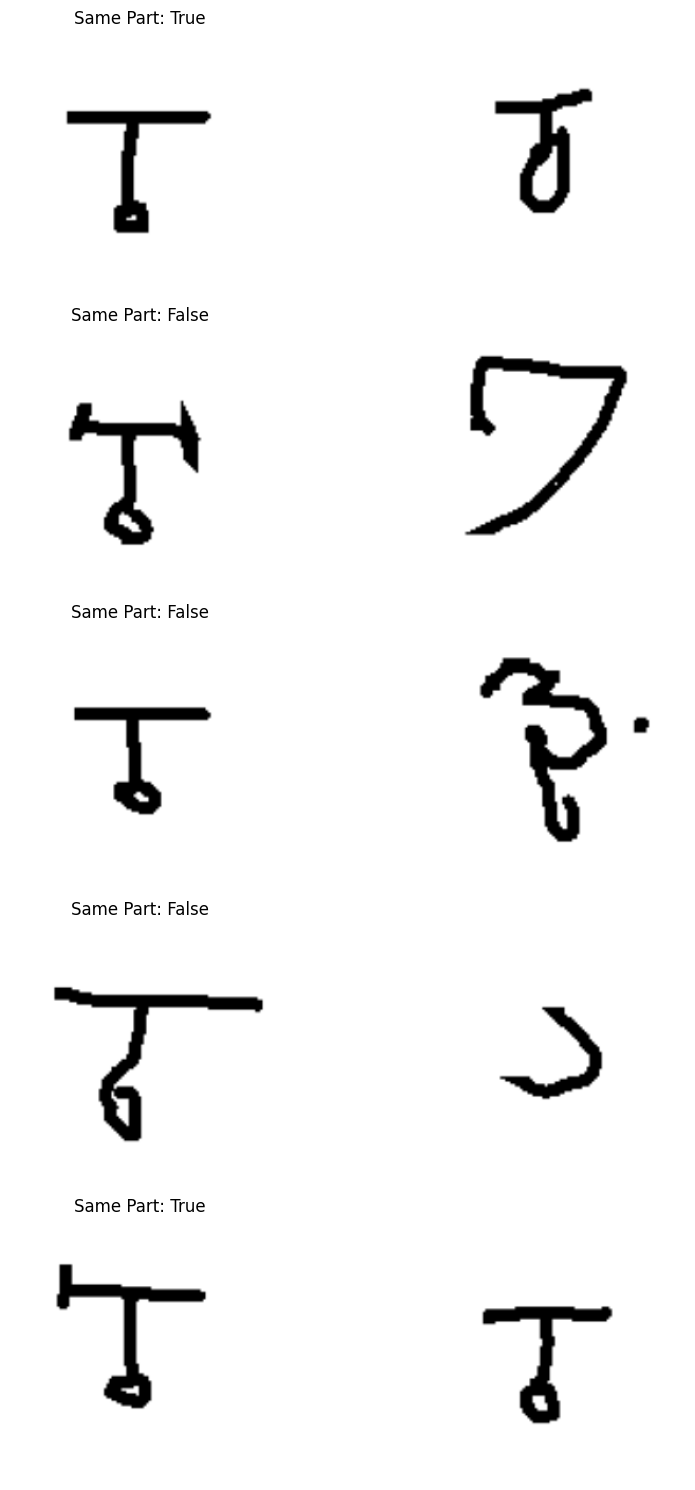

In [4]:
def show_pairs(dataset, num_pairs=5):
    """Visualize sample pairs from dataset"""
    fig, axes = plt.subplots(num_pairs, 2, figsize=(10, num_pairs*3))
    
    for i in range(num_pairs):
        img1, img2, label = dataset[i]
        print(label)
        
        # Denormalize images
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img1 = img1 * std + mean
        img2 = img2 * std + mean
        
        axes[i, 0].imshow(img1.permute(1, 2, 0).clip(0, 1))
        axes[i, 1].imshow(img2.permute(1, 2, 0).clip(0, 1))
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
        axes[i, 0].set_title(f'Same Part: {bool(label)}')
    
    plt.tight_layout()
    plt.show()

show_pairs(train_dataset)

## 4. Model Setup and Training Functions

In [5]:
def plot_img_pairs(img1, img2, label):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img1 = img1 * std + mean
    img2 = img2 * std + mean
    
    axes[0].imshow(img1.permute(1, 2, 0).clip(0, 1))
    axes[1].imshow(img2.permute(1, 2, 0).clip(0, 1))
    axes[0].axis('off')
    axes[1].axis('off')
    axes[0].set_title(f'Same Part: {bool(label)}')
    
    plt.tight_layout()
    plt.show()


def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for img1, img2, labels in pbar:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).unsqueeze(1)
        
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        predicted = (outputs >= 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    return running_loss / len(train_loader), 100 * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for img1, img2, labels in tqdm(val_loader, desc='Validating'):
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).unsqueeze(1)
            
            outputs = model(img1, img2)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(outputs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return running_loss / len(val_loader), 100 * correct / total, all_preds, all_labels

## 5. Initialize Model and Training Components

In [6]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, 
                         shuffle=True, num_workers=config.num_workers)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size,
                       shuffle=False, num_workers=config.num_workers)

# Initialize model
model = SiameseNetwork(embedding_dim=config.embedding_dim).to(device)

# Loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3)

# Optional: Initialize wandb
# wandb.init(project='auto-parts-matching', config=config)

## 6. Training Loop with Monitoring

In [7]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0

for epoch in tqdm(range(config.num_epochs)):
    print(f'\nEpoch {epoch+1}/{config.num_epochs}')
    
    # Training
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validation
    val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Log metrics
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%')
    
    # Optional: Log to wandb
    # wandb.log({
    #     'train_loss': train_loss,
    #     'train_acc': train_acc,
    #     'val_loss': val_loss,
    #     'val_acc': val_acc
    # })
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), config.model_save_path)
        print(f'Saved new best model with validation accuracy: {val_acc:.2f}%')
    
    # Update learning rate
    scheduler.step(val_loss)

  0%|          | 0/50 [00:00<?, ?it/s]


Epoch 1/50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

Validating:   0%|          | 0/25 [00:00<?, ?it/s]

Train Loss: 0.6931 | Train Acc: 48.50%
Val Loss: 0.6921 | Val Acc: 56.25%
Saved new best model with validation accuracy: 56.25%

Epoch 2/50


Training:   0%|          | 0/25 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 7. Analyze Training Results

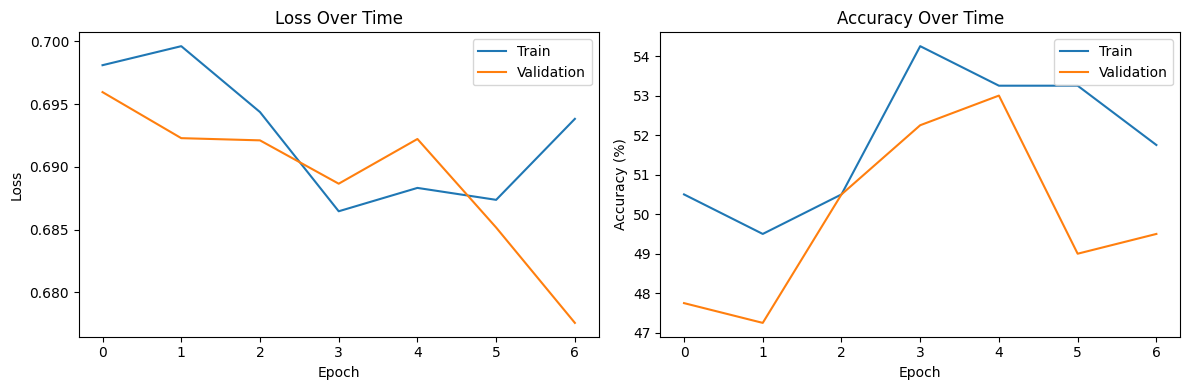

In [8]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

## 8. Model Evaluation and Error Analysis